In [1]:
lines = []

with open("./data/day18.txt") as f:
    while line := f.readline():
        line = line.rstrip()
        lines.append(line.split())
        lines[-1][1] = int(lines[-1][1])
        lines[-1][-1] = lines[-1][-1].replace('(', '').replace(')', '')

# Part 1

We'll track the path that is dug, then shift the coordinates to all be positive and plot them in a grid. Finally we'll run BFS from outside the dug path to find the outside grid locations to calculate the area inside the path, i.e. the part 1 solution.

In [2]:
holes = [[0, 0]]

node = [0, 0]
for direction, count, _ in lines:
    if direction == 'R':
        for _ in range(count):
            node[1] += 1
            holes += [node.copy(),]
    elif direction == 'L':
        for _ in range(count):
            node[1] -= 1
            holes += [node.copy(),]
    elif direction == 'D':
        for _ in range(count):
            node[0] += 1
            holes += [node.copy(),]
    elif direction == 'U':
        for _ in range(count):
            node[0] -= 1
            holes += [node.copy(),]
min_row = min(holes, key=lambda x: x[0])[0]
min_col = min(holes, key=lambda x: x[1])[1]
min_row, min_col

(-233, 0)

Shift the path to only have positive coordinates:

In [3]:
for i in range(len(holes)):
    holes[i][0] -= min_row-1
    holes[i][1] -= min_col-1

In [4]:
min(holes, key=lambda x: x[0])[0], min(holes, key=lambda x: x[1])[1]

(1, 1)

In [5]:
max_row = max(holes, key=lambda x: x[0])[0]
max_col = max(holes, key=lambda x: x[1])[1]
max_row, max_col

(421, 381)

For our grid, we'll also add an extra row and column to the end to completely connect the outside.

In [6]:
grid = [[0]*(max_col+2) for _ in range(max_row+2)]

for row, col in holes:
    grid[row][col] = 1

q = [(0, 0)]
visited = set()
visited.add((0, 0))
while q:
    row, col = q.pop()
    for x, y in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        if (0 <= row+x <= max_row+1) and (0 <= col+y <= max_col+1) and (row+x, col+y) not in visited and grid[row+x][col+y] == 0:
            visited.add((row+x, col+y))
            q.append((row+x, col+y))

Plot the dug holes into a grid where `0` indicates no hole and `1` indicates a hole.

In [7]:
grid_filled = [[1]*(max_col+2) for _ in range(max_row+2)]

for x, y in visited:
    grid_filled[x][y] = 0

In [8]:
sum([sum(row) for row in grid_filled])

52231

In [9]:
import numpy as np
import matplotlib.pyplot as plt

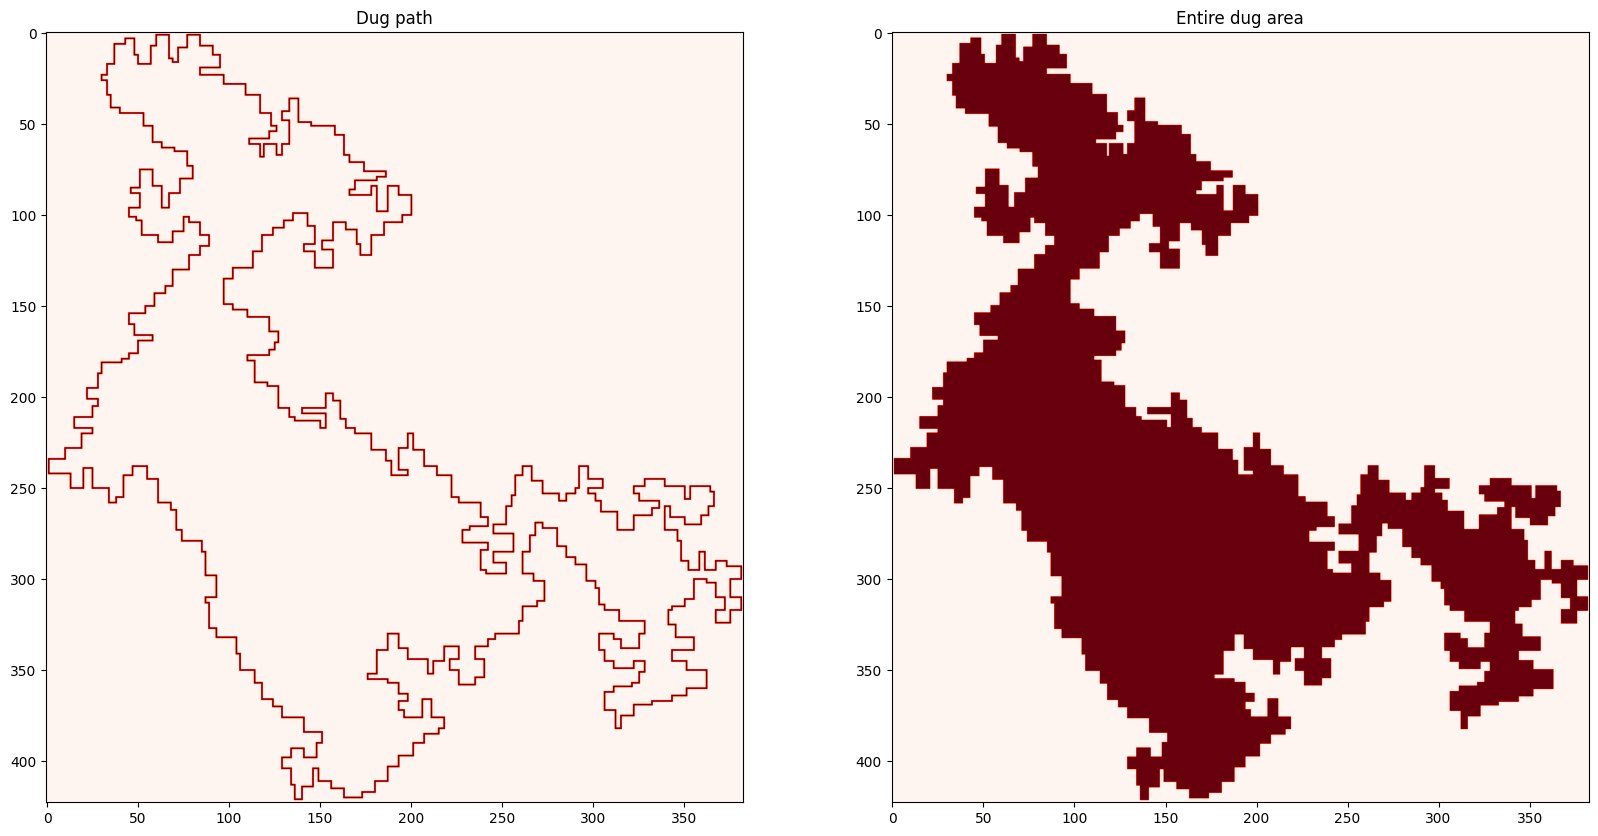

In [10]:
arr = np.array(grid)
arr_filled = np.array(grid_filled)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(arr, cmap=plt.cm.Reds)
axs[0].set_title('Dug path')
axs[1].imshow(arr_filled, cmap=plt.cm.Reds)
axs[1].set_title('Entire dug area');

# Part 2

The grid will be gigantic (order of $10^{14}$ squares) so flood filling or ray casting etc. will not work. We will use a formula that computes the area covered by a polygon given an ordered list of vertices. Specifically the [Shoelace/Trapezoid formula](https://en.wikipedia.org/wiki/Shoelace_formula#Trapezoid_formula). To see what the formula actually computes when we give it the list of the corners of our path, let's visualize the polygon the corners of the example input plot in part 1.

In [11]:
lines = []

with open("./data/day18_ex.txt") as f:
    while line := f.readline():
        line = line.rstrip()
        lines.append(line.split())
        lines[-1][1] = int(lines[-1][1])
        lines[-1][-1] = lines[-1][-1].replace('(', '').replace(')', '')

In [12]:
holes = [[0, 0]]

node = [0, 0]
for direction, count, _ in lines:
    if direction == 'R':
        for _ in range(count):
            node[1] += 1
            holes += [node.copy(),]
    elif direction == 'L':
        for _ in range(count):
            node[1] -= 1
            holes += [node.copy(),]
    elif direction == 'D':
        for _ in range(count):
            node[0] += 1
            holes += [node.copy(),]
    elif direction == 'U':
        for _ in range(count):
            node[0] -= 1
            holes += [node.copy(),]

corners = [[0, 0]]

node = [0, 0]
for direction, count, _ in lines:
    if direction == 'R':
        node[1] += count
        corners += [node.copy(),]
    elif direction == 'L':
        node[1] -= count
        corners += [node.copy(),]
    elif direction == 'D':
        node[0] += count
        corners += [node.copy(),]
    elif direction == 'U':
        node[0] -= count
        corners += [node.copy(),]

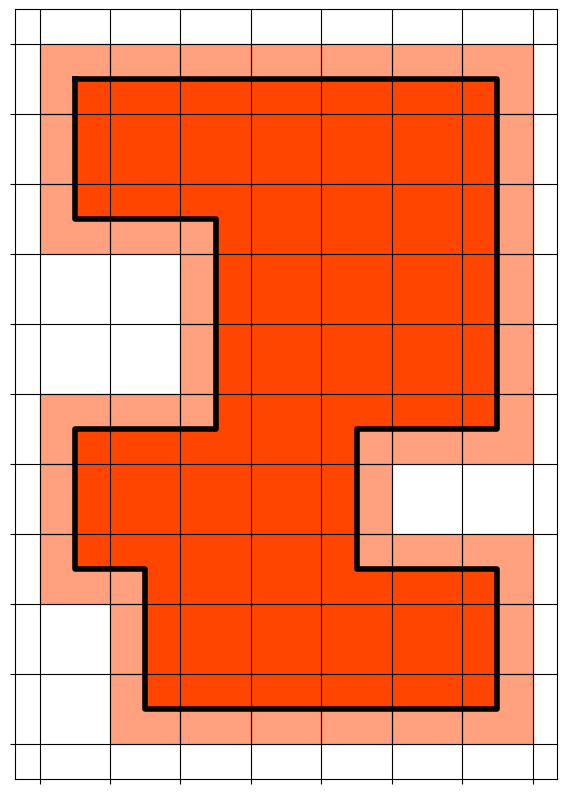

In [13]:
fig, ax = plt.subplots(figsize=(7, 10))

ax.fill([col for _, col in corners], [-row for row, _ in corners], color='orangered')
ax.plot([col for _, col in corners], [-row for row, _ in corners], color='black', lw=4)
for row, col in holes[:-1]:
    ax.fill([col-.5, col+.5, col+.5, col-.5], [-row-.5, -row-.5, -row+.5, -row+.5], color='orangered', alpha=.5)
ax.set_xticks(np.arange(-.5, 7., 1.))
ax.set_yticks(np.arange(.5, -10., -1.))
ax.grid(color='black')
ax.set_xticklabels([])
ax.set_yticklabels([]);

This picture illustrates the area that we are trying to compute versus the area that the Trapezoid formula will compute when we simply give it the list of the corners of our path. The path is drawn in black and the squares that are dug are colored in orange. The area covered by the path that is not inside the black line is
$$\frac{\text{len}(\text{path})}{2} + 1.$$
This can be seen by noting that
- a straight part of the path has half of the square not counted,
- an inward turn has three quarters of the square not counted,
- an outward turn has one quarter of the square not counted,
- and there are always four more inward turns that outward turns in the path that tracks the outside.

Let's illustrate that this difference actually works with the part 1 example and my actual part 1 input.

In [14]:
# Trapezoid formula

res = 0
for i in range(len(corners)-1):
    res += (corners[i][1]+corners[i+1][1])*(corners[i][0]-corners[i+1][0])
res = abs(res//2)

print('The Trapezoid formula gives', res)
print('The actual area was', 62)
print('Difference = ', 62-res)
print('len(path)/2 + 1 = ', 38//2 + 1)

The Trapezoid formula gives 42
The actual area was 62
Difference =  20
len(path)/2 + 1 =  20


Works for the example. Now my part 1 input:

In [15]:
lines = []

with open("./data/day18.txt") as f:
    while line := f.readline():
        line = line.rstrip()
        lines.append(line.split())
        lines[-1][1] = int(lines[-1][1])
        lines[-1][-1] = lines[-1][-1].replace('(', '').replace(')', '')

path_len = 0
corners = [[0, 0]]

node = [0, 0]
for direction, count, _ in lines:
    path_len += count
    if direction == 'R':
        node[1] += count
        corners += [node.copy(),]
    elif direction == 'L':
        node[1] -= count
        corners += [node.copy(),]
    elif direction == 'D':
        node[0] += count
        corners += [node.copy(),]
    elif direction == 'U':
        node[0] -= count
        corners += [node.copy(),]

# Trapezoid formula

res = 0
for i in range(len(corners)-1):
    res += (corners[i][1]+corners[i+1][1])*(corners[i][0]-corners[i+1][0])
res = abs(res//2)

print('The Trapezoid formula gives', res)
print('The actual area was', 52231)
print('Difference = ', 52231-res)
print('len(path)/2 + 1 = ', path_len//2 + 1)

The Trapezoid formula gives 50226
The actual area was 52231
Difference =  2005
len(path)/2 + 1 =  2005


Still works! Now we just need to reparse the input for part 2 and run the calculation.

In [16]:
lines = []

with open("./data/day18.txt") as f:
    while line := f.readline():
        lines.append([])
        line = line.rstrip()
        lines[-1].append('R' if line[-2] == '0' else 'D' if line[-2] == '1' else 'L' if line[-2] == '2' else 'U')
        lines[-1].append(int(line[-7:-2], 16))

In [17]:
path_len = 0
corners = [[0, 0]]

node = [0, 0]
for direction, count in lines:
    path_len += count
    if direction == 'R':
        node[1] += count
        corners += [node.copy(),]
    elif direction == 'L':
        node[1] -= count
        corners += [node.copy(),]
    elif direction == 'D':
        node[0] += count
        corners += [node.copy(),]
    elif direction == 'U':
        node[0] -= count
        corners += [node.copy(),]

In [18]:
# Trapezoid formula

res = 0
for i in range(len(corners)-1):
    res += (corners[i][1]+corners[i+1][1])*(corners[i][0]-corners[i+1][0])
abs(res//2)+(path_len//2)+1

57196493937398